In [1]:
__author__ = "Rahul Raj"
__copyright__ = "Copyright 2019, Credits to Original authors of paper 'Truth Will Out'"
__credits__ = ["Wissam Aoudi", "Mikel Iturbe", "Magnus Almgren"]
__license__ = "GPL"
__version__ = "3"
__maintainer__ = "Rahul Raj"
__email__ = "rahulrajpl@gmail.com"
__status__ = "Academic/ Development"

In [2]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel, eigh
from matplotlib import pyplot as plt
from matplotlib import style

## Data fetching and cleaning for analysis.

In [3]:
xmeas = np.asarray(pd.read_csv('xmv6_twentyeight_data_1.csv', usecols=[9], header=None))

In [4]:
X_train_data = xmeas[:500] # For training 
X_theta = xmeas[250:4000] # For threshold calculation
X_test = xmeas[3750:] # For detection

## Embedding (Creating Lag Covariance Matrix)

In [5]:
N = len(X_train_data)
L = N // 2
X_train = hankel(X_train_data[:L],X_train_data[L-1:]) # Creating trajectory matrix

## Singular Value Decomposition of Log Covariance matrix (Trajectory Matrix above)

Text(0.5, 0, 'Cardinal Number of Eigen value ->')

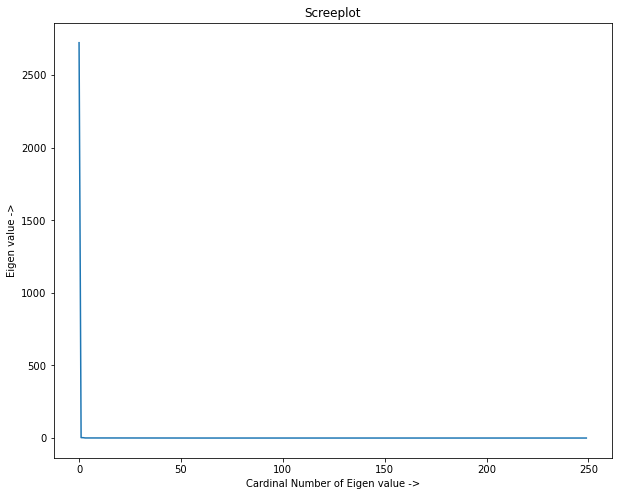

In [6]:
eigenValues, eigenVectors = eigh(np.matmul(X_train, X_train.T))
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
# Sree plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(eigenValues)
ax.set_title("Screeplot")
ax.set_ylabel("Eigen value ->")
ax.set_xlabel("Cardinal Number of Eigen value ->")

## Projection onto signal subspace

In [7]:
# From the above scree plot, it is seen that the first eigen value is more 
# significant and the other eigen values are close to zero. Thus we choose r as 1
# and then we compute the U for projection and centroid in the signal subspace
r = 1
# Extracted Training signals
U, Sigma, V = np.linalg.svd(X_train)
V = V.T
# d = np.linalg.matrix_rank(X_train)
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,r)] )
X_train_extracted = X_elem.sum(axis=0)
X_train_extracted_data = np.asarray(list(X_train_extracted[:,0]) + list(X_train_extracted[:,-1]))

U = eigenVectors[:,:r] # r as statistical dimension
UT = U.T
pX = np.matmul(UT,X_train_extracted)
centroid = np.mean(pX, axis=1)
centroid = centroid[:,np.newaxis]


## Distance Tracking and Threshold Calculation

In [8]:
# Calculating the departure threshold in signal subspace using centroid and UT

#For training phase
Xtrg = hankel(X_train_data[:L], X_train_data[L-1:])
pXtrg = np.matmul(UT,Xtrg)
dtrg_matrix = centroid - pXtrg
dtrg_scores = np.linalg.norm(dtrg_matrix, axis=0, ord=2)

# For Validation phase and threshold calculation
Xt = hankel(X_theta[:L],X_theta[L-1:])
pXt = np.matmul(UT,Xt)
dt_matrix = centroid - pXt
dt_scores = np.linalg.norm(dt_matrix, axis=0, ord=2)
# d_scores = np.asarray([np.matmul(d_matrix[:,i].T, d_matrix[:,i]) for i in range(d_matrix.shape[1])])
dt_theta = np.max(dt_scores)
dt_theta


0.174306384520579

## Testing Phase

In [9]:
Xj = hankel(X_test[:L],X_test[L-1:])

In [10]:
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
# dj_scores = [np.matmul(dj_matrix[:,i].T, dj_matrix[:,i]) for i in range(dj_matrix.shape[1])]
dj_scores = np.asarray(dj_scores)
np.max(dj_scores)

0.30587154398867344

## Plotting and Visualizing

/var/folders/8f/5f00v5l94r91mtfll9t0x2sm0000gn/T/ipykernel_93005/3934046436.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlables)
/var/folders/8f/5f00v5l94r91mtfll9t0x2sm0000gn/T/ipykernel_93005/3934046436.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
/var/folders/8f/5f00v5l94r91mtfll9t0x2sm0000gn/T/ipykernel_93005/3934046436.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlables)
/var/folders/8f/5f00v5l94r91mtfll9t0x2sm0000gn/T/ipykernel_93005/3934046436.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is 

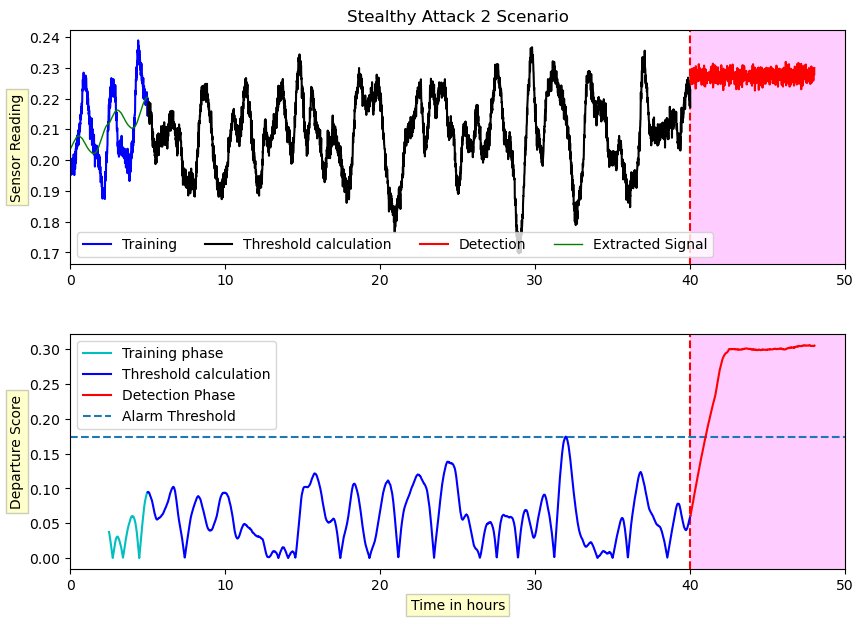

In [11]:
#Testing Plots and Subplots
style.use('default')
box = dict(facecolor='yellow', pad=3, alpha=0.2)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.set_xlim(0,5000)
ax2.set_xlim(0,5000)
# ax2.set_ylim(0,10)

plt.subplots_adjust(hspace =0.3)

xlables = list(range(0,5000,10)) # for both plots

# Plotting signal reading
xmeasx_1 = list(range(501))
xmeasx_2 = list(range(501, 4001))
xmeasx_3 = list(range(4001,len(xmeas)))
ax1.plot(xmeasx_1, xmeas[:501] ,'b', label='Training') # Plot of Training Data
ax1.plot(xmeasx_2, xmeas[501:4001] ,'k', label='Threshold calculation') # Plot of Threshold Determination Data
ax1.plot(xmeasx_3, xmeas[4001:] ,'r', label='Detection') # Plot of Detection Phase
ax1.plot(X_train_extracted_data, 'g', linewidth=1, label='Extracted Signal' )
ax1.set_xticklabels(xlables)
ax1.title.set_text('Stealthy Attack 2 Scenario')
ax1.set_ylabel('Sensor Reading', bbox=box)
ylim = list(ax1.get_ylim())
ax1.vlines(4000,ylim[0],ylim[1],linestyles='dashed', colors='r')
X = np.array([[4000,5000],[4000,5000]])
Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
C = np.array([[4000,4500]])
ax1.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
ax1.legend(loc='best', ncol=4)


# Plotting departure score
dy = dtrg_scores
dx = list(range(L,len(dy)+L))
ax2.plot(dx, dy, 'c', label='Training phase')
dy = dt_scores
dx = list(range(500,len(dy)+500))
ax2.plot(dx, dy, 'b', label='Threshold calculation')
dy = dj_scores
dx = list(range(4000,len(dy)+4000))
ax2.plot(dx, dy, 'r', label='Detection Phase')
ylim = list(ax2.get_ylim())
ax2.vlines(4000,ylim[0],ylim[1],linestyles='dashed', colors='r')
ax2.set_xticklabels(xlables)
ax2.hlines(dt_theta,0,5000,linestyles='dashed', label='Alarm Threshold')
ax2.set_xlabel('Time in hours', bbox=box)
ax2.set_ylabel('Departure Score', bbox=box)

X = np.array([[4000,5000],[4000,5000]])
Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
C = np.array([[4000,4500]])
ax2.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
ax2.legend(loc='upper left')
fig.align_ylabels([ax1,ax2])